In this post, I would like to discuss a very simple language model based on n-grams. The goal of the model is to get familiar with common names for people, and be able to create new name-like sounding words. We will use `nntrain` library we build [earlier](https://lucasvw.github.io/posts/08_nntrain_setup/) to train our models. The idea for this comes from Andrej Karpahy's [lecture series](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ) on Neural Networks

## Data

Let's get some data and have a first look at it:

In [ ]:
from pathlib import Path
from urllib.request import urlretrieve
import torch
import matplotlib.pyplot as plt
import torcheval.metrics as tem
import fastcore.all as fc

from nntrain.dataloaders import DataLoaders
from nntrain.learner import *
from nntrain.activations import *

In [ ]:
path = Path('./data')
path.mkdir(parents=True, exist_ok=True)
path = path / 'names.txt'
url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'

_ = urlretrieve(url, path)

In [ ]:
with open(path, 'r') as f:
    lines = f.read().splitlines()

print('first 5 names in array: ', end=' ')
print(lines[0:5])
print(f'{len(lines)=}')

first 5 names in array:  ['emma', 'olivia', 'ava', 'isabella', 'sophia']
len(lines)=32033


An n-gram language model is probably the simplest language model there is. Like most (any?) language model, it tries to predict the next token (character, word or word-part...) following a sequence of tokens. The "n" in n-gram reflects to the length of the used context. The bi-gram model, only the previous token is used to predict the next one, in a tri-gram model the previous two tokens are used.

Let's clearify what we mean with "try to predict the next token": an n-gram model learns a probability distribution over any of the tokens that can follow from any of the possible contexts. A bi-gram character level model has thus a learned probability distribition over all the characters ("a" through "z", and let's add a token to denote the "end of a word", so 26+1 tokens) that can follow from any character ("a" throguh "z", plus a token for "start of a word").

The simplest possible way to *learn* a probability distribition from training data, is by simply keeping track of the statistics in the training corpus: go through all the n-grams present in the document and count the occurences. If we then normalize these counts (by dividing through the sum) we have a probability distribution.

Let's do this. First we will have a quick look at the data:

## Count model

In [ ]:
unique_chars = list(set("".join(lines)))
unique_chars.sort()
print(f'{unique_chars=}')
print(f'{len(unique_chars)=}')

unique_chars=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
len(unique_chars)=26


In [ ]:
# Let's initialize a counts matrix where the rows represent the previous character
# and the columns represent the character that follows.
counts = torch.zeros([27,27], dtype=int)

# Create a mapping from character to index and reversed:
c2i = {c:i for i, c in enumerate(unique_chars + ['.'])}
i2c = {i:c for i, c in enumerate(unique_chars + ['.'])}

In [ ]:
cutoff = round(len(lines) * 0.8)
train_lines = lines[:cutoff]
val_lines = lines[cutoff:]

for name in train_lines:                              # iterate through all the names
    name = "." + name + "."                           # add start and end token
    bigrams = zip(name[:-1], name[1:])                # create tuples of bigrams
    for bigram in bigrams:                            # iterate through tuples
        counts[c2i[bigram[0]], c2i[bigram[1]]] +=1    # increase the counts in the matrix

And let's visualize the weight matrix. On the vertical axis (the rows of the matrix) we have the "context" characters and on the horizontal axis (the columns of the matrix) we display the characters that follow. White means low counts, and dark blue means high counts. So we see for example that the matrix is actually quite sparse. Many bigrams appear very few times, and a couple of ones occur very frequently. For example:

- Looking at the first row: an "a" is followed very often either with an "n" or even more often by a ".", meaning the "a" is the last character in the word
- Looking at the last row: names start most often with an "a"

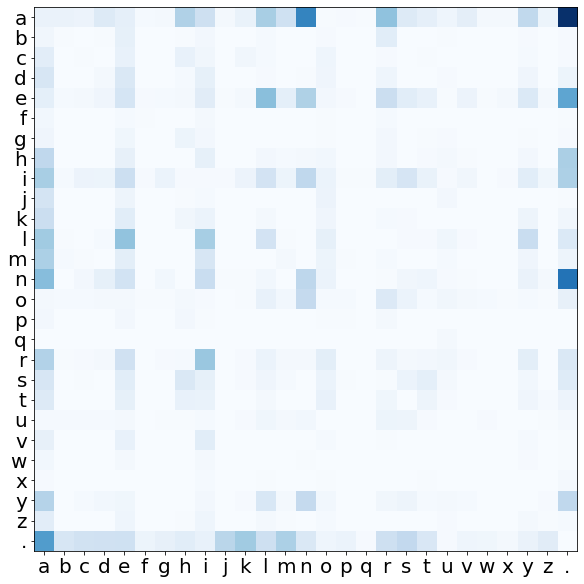

In [ ]:
#| #| code-fold: true

fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(counts, cmap='Blues');
ax.set_xticks(list(range(0,27)), list(c2i.keys()));
ax.set_yticks(list(range(0,27)), list(c2i.keys()));
ax.tick_params(axis='both', which='major', labelsize=20);

Let's use this language model to generate some new names:

In [ ]:
# Normalize over the rows
probs = counts / counts.sum(dim=1, keepdim=True)

In [ ]:
g = torch.Generator().manual_seed(42)

names = []
for i in range(10):                           # generate 20 names
    name = '.'                                # initialize each name with a starting token
    while True:                               # loop until break
        i = c2i[name[-1]]                     # index of last character
        pdf = probs[i]                        # pdf over characters that follow from last character
        s = torch.multinomial(pdf, 1, generator=g) # draw a sample given the pdf
        c = i2c[s.item()]                     # transform to character
        name += c                             # append new character to name
        if c == '.':                          # stop sampling upon reaching an end of word token
            names.append(name)                # store away sampled name
            break

In [ ]:
names

['.akyleloniatanacaroleynn.',
 '.con.',
 '.thmarie.',
 '.di.',
 '.n.',
 '.kahannoa.',
 '.jadde.',
 '.ethann.',
 '.dalaydah.',
 '.loeshana.']

Not that great names.. I guess it's not surprising giving the simplicity of this model

## Neural network

It turns out that the bi-gram model above, has an equivalence to a simple neural network that's composed of an embedding matrix and uses cross-entropy loss. The output of the embedding layer is what we refer to as the logits and they are the "raw" output of the neural network.  These output numbers can be anything, positive, negative, small or large. 

We can exponentiate these logits to get numbers that are always positive, and these values are equivalent to values in the "counts" matrix. We can then normalize these exponentiated logits row-wise, to get to probabilities. And finally adding a negative log-likelihood loss on these probabilities is guiding the network to establish an embedding matrix with weights that are practically identical to the log transformed counts matrix from above. The combined operation of exponentiating, normalizing and negative log-likelihood is what we call cross-entropy loss. See also an earlier blog [post](https://lucasvw.github.io/posts/05_crossentropy/).

But why go through this hassle? The problem with the counts based approach, is that we don't really have a good strategy to increase the performance of this model. The only obvious way, would be to increase the context length (3-grams, 4-grams etc). However we can't keep doing this forever. Since the counts matrix is going to be very sparse since the amount of rows in an n-gram model increases with $27^n$. The advantage of this new neural network approach over the counts based approach is that we can gradually increase the complexity of the neural network to get better results.

We are going to train this model using `nntrain`, the small neural network training library we have been created before.

Let's start with the data, the datasets and the dataloaders. And let's make the dataset generic so that it can create datasets for any n-gram model we wish. To do so, let's have a quick look how 2-grams, 3-grams and 4-grams look for the first name in the data *Emma*:

In [ ]:
#| #| code-fold: true

name = lines[0]
name = '.' + name + '.'
print('2-grams:')
for i in zip(name[:-1], name[1:]):
    print(i[0], '--->', i[1])

2-grams:
. ---> e
e ---> m
m ---> m
m ---> a
a ---> .


In [ ]:
#| #| code-fold: true

name = lines[0]
name = '..' + name + '.'
print('3-grams:')
for i in zip(name[:-2], name[1:-1], name[2:]):
    print(i[0], i[1], '--->', i[2])

3-grams:
. . ---> e
. e ---> m
e m ---> m
m m ---> a
m a ---> .


In [ ]:
#| #| code-fold: true

name = lines[0]
name = '...' + name + '.'
print('4-grams:')
for i in zip(name[:-3], name[1:-2], name[2:-1], name[3:]):
    print(i[0], i[1], i[2], '--->', i[3])

4-grams:
. . . ---> e
. . e ---> m
. e m ---> m
e m m ---> a
m m a ---> .


We observe:

- irrespective of n, we always end up with the same amount of samples
- when we increase the context to n=3 and n=4, we need to add additional start-word tokens to make sure we don't skip the first sample(s)

Let's create a dataset that does this:

In [ ]:
class NgramDataset():
    def __init__(self, lines, n=2):
        self.x = []    # store the xs, the context, the left hand side of the bigram
        self.y = []    # store the ys, the labels, the right hand side of the bigram
        for line in lines:           
            x = '.'*(n-1)         # the first x is always full of start word tokens
            for y in line + '.':  # the first y is always the first letter of the name
                self.x.append([c2i[xi] for xi in x])  # convert to int and store
                self.y.append(c2i[y])                 # convert to int and store
                x = (x + y)[1:]                       # update x
        self.x = torch.tensor(self.x).squeeze()       # from list to tensor 
        self.y = torch.tensor(self.y).squeeze()       # from list to tensor
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.x)

Next, let's create the model, which should also be able to deal with n-grams. For that purpose we don't use an `nn.Embedding` layer since they are only two dimensional. For an n-gram of n > 2, we would then have to stack-up all the different possible character combinations of the context in the row dimension. This is a bit tedious to implement, so instead we will use an explicit n-dimensional weight tensor. For the trigram this means: the first (second) dimension is for the first (second) character in the context, and the last dimension is for the label.

In [ ]:
class NgramNet(torch.nn.Module):
    def __init__(self, n=2):
        super().__init__()
        self.embedding = torch.nn.Parameter(torch.randn((27,)*n).requires_grad_())
        
    def forward(self, x):
        # logits are obtained by indexing into the embedding matrix
        logtis = self.embedding[x] 
        return logits

In [ ]:
train_ds = NgramDataset(train_lines)
val_ds = NgramDataset(val_lines)

bs = 10000
train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=bs)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bs*2)
dls = DataLoaders(train_loader, val_loader)

epoch,mode,loss
0,train,3.089
0,eval,2.715
1,train,2.500
1,eval,2.620
2,train,2.441
2,eval,2.602
3,train,2.432
3,eval,2.599
4,train,2.430
4,eval,2.595


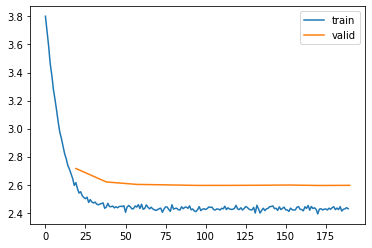

In [ ]:
m = NgramNet()

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device)]

l = Learner(m, dls, torch.nn.functional.cross_entropy, torch.optim.Adam, None, subs=subs)
l.fit(10, lr=1e-1)

Now, let's patch our module with an inference method, which generates names for us. We can pass in a generator to make sure we get the same random behavior as we have seen above when generating names with the counts model:

In [ ]:
@fc.patch
def generate(self:NgramNet, n=10, generator=None):
    names = []
    for i in range(n):
        name = '.'
        while True:
            i = c2i[name[-1]]
            pdf = self.embedding[i]
            s = torch.multinomial(pdf.exp().detach().cpu(), 1, generator=generator)
            c = i2c[s.item()]
            name += c
            if c == '.':
                names.append(name)
                break
    return names

In [ ]:
m.generate(generator=torch.Generator().manual_seed(42))

['.akyleloniatanacaroleynn.',
 '.con.',
 '.thmarie.',
 '.al.',
 '.n.',
 '.kahannoa.',
 '.jadde.',
 '.ethann.',
 '.dalaydah.',
 '.loeshana.']

These names are extremely similar to the ones we created above. This shows that both models are converging to eachother. In fact, it can be mathematically shown that they are identical.

We can also have a look at both the weight matrices to see that the embedding matrix is extremely similar to the counts matrix:

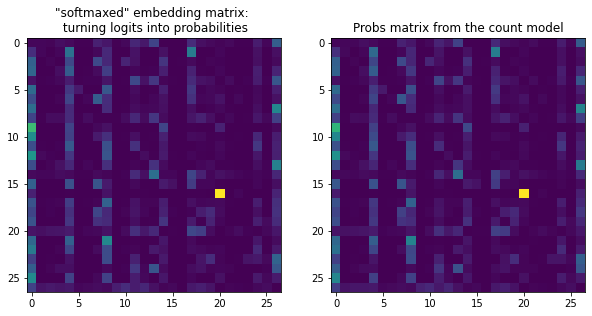

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(torch.nn.functional.softmax(m.embedding.detach().cpu(), dim=1).numpy());
axs[0].set_title('"softmaxed" embedding matrix: \n turning logits into probabilities');
axs[1].imshow(probs);
axs[1].set_title('Probs matrix from the count model');